<a href="https://colab.research.google.com/github/NyafeuKamdem/retail_demand_forcasting/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data_Prep**

##**Data Preparation Pipeline: From Drive to Clean Sample**

###**STEP 1: Import packages**

In [1]:
# Importing the needed packages.
import numpy as np                                                # For numerical operation arraywise.
import pandas as pd                                               # For Data manipulation.
import matplotlib.pyplot as plt                                   # For basic visualization's functions.
import seaborn as sns                                             # For advance visualization's functions.
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd  # pwd = 'print working directory' tels us where we are

/content


In [3]:
%cd drive/MyDrive/ # cd = 'change directory'

[Errno 2] No such file or directory: 'drive/MyDrive/ # cd = change directory'
/content


In [4]:
!pwd

/content


###**STEP 2: Read all files except train.csv**

In [6]:
# STEP 3: Read all files but train.csv

df_holiday_events = pd.read_csv('/content/drive/MyDrive/favorita/holidays_events.csv')
df_items          = pd.read_csv('/content/drive/MyDrive/favorita/items.csv')
df_oil            = pd.read_csv('/content/drive/MyDrive/favorita/oil.csv')
df_stores         = pd.read_csv('/content/drive/MyDrive/favorita/stores.csv')
df_transactions   = pd.read_csv('/content/drive/MyDrive/favorita/transactions.csv')

###**STEP 3:Load stores and get Guayas store IDs**

In [ ]:
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

###**STEP 4: Read train.csv in chunks and filter for Guayas region**

In [ ]:
# STEP 6: Read train.csv in chunks and filter for Guayas region
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv('/content/drive/MyDrive/favorita/train.csv', chunksize = chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk

/tmp/ipython-input-3821781864.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/favorita/train.csv', chunksize = chunk_size):


###**STEP 5: Combine and sample**

In [ ]:
# STEP 5: Combine and sample
df_train = pd.concat(filtered_chunks, ignore_index=True).sample(n=2_000_000).reset_index(drop=True)

In [ ]:
df_train.shape

(2000000, 6)

###**STEP 6: Clean up memory and save df_train as a pickle file**

In [ ]:
len(filtered_chunks)
del filtered_chunks

In [ ]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [ ]:
# top1 family with 'perishable' items

df_items_perish = df_items[df_items['perishable']==1]
top1_family_per_perish_item = df_items_perish['family'].value_counts().reset_index()
top1_family_per_perish_item

,family,count
0,PRODUCE,306
1,DAIRY,242
2,BREAD/BAKERY,134
3,DELI,91
4,MEATS,84
5,POULTRY,54
6,EGGS,41
7,PREPARED FOODS,26
8,SEAFOOD,8


In [ ]:
# SELECT THE TOP 3 FAMILIES(IN TERMS OF NUMBER OF ITEM) + A FAMILY OF 'PERISHABLE' ITEMS

top3_family_per_item = df_items['family'].value_counts().reset_index()
top3_family_per_item = top3_family_per_item.rename(columns = {'count': 'item quantity'}, inplace = False)
top3_family_per_item = top3_family_per_item[:3] # top3_family_per_item = top3_family_per_item.head(3)
top3_family_per_item

,family,item quantity
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


In [ ]:
families = top3_family_per_item['family'].unique().tolist()
families.append(top1_family_per_perish_item['family'][0])
families

['GROCERY I', 'BEVERAGES', 'CLEANING', 'PRODUCE']

In [ ]:
# CREATE THE LIST OF ITEM'S IDS AND USE IT TO FILTER THE DATA FRAME.

item_ids = [x for x in df_items[df_items['family'].isin(families)]['item_nbr']]

df_train = df_train[df_train['item_nbr'].isin(item_ids)]
df_train.shape

(1398849, 6)

In [ ]:
# Path to save the file
save_path = "/content/drive/MyDrive/tsa_ms_project/df_train.pkl"

# Save DataFrame
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")

Saved to: /content/drive/MyDrive/tsa_ms_project/df_train.pkl


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Drive
drive.mount('/content/drive')

# Path to load the file
load_path = "/content/drive/MyDrive/tsa_ms_project/df_train.pkl"

# Load DataFrame
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


##**EDA**

###**Step 1: df Inspection**

In [ ]:
df_train.isna().mean()*100

,0
id,0.000000
date,0.000000
store_nbr,0.000000
item_nbr,0.000000
unit_sales,0.000000
onpromotion,17.575735


In [ ]:
df_train["onpromotion"].value_counts(normalize = True)*100

,proportion
onpromotion,
False,93.343053
True,6.656947


In [ ]:
# Givent that +92% of products are not in promotion, we will fill the missing values with FALSE
onpromotion_mode = df_train['onpromotion'].mode()[0]
df_train['onpromotion'] = df_train['onpromotion'].fillna(onpromotion_mode)

/tmp/ipython-input-2418119189.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(onpromotion_mode)


In [ ]:
df_train.isna().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


###**Step 2: Handling Outliers**

In [ ]:
num_cols_to_plot = ['store_nbr', 'item_nbr', 'unit_sales']

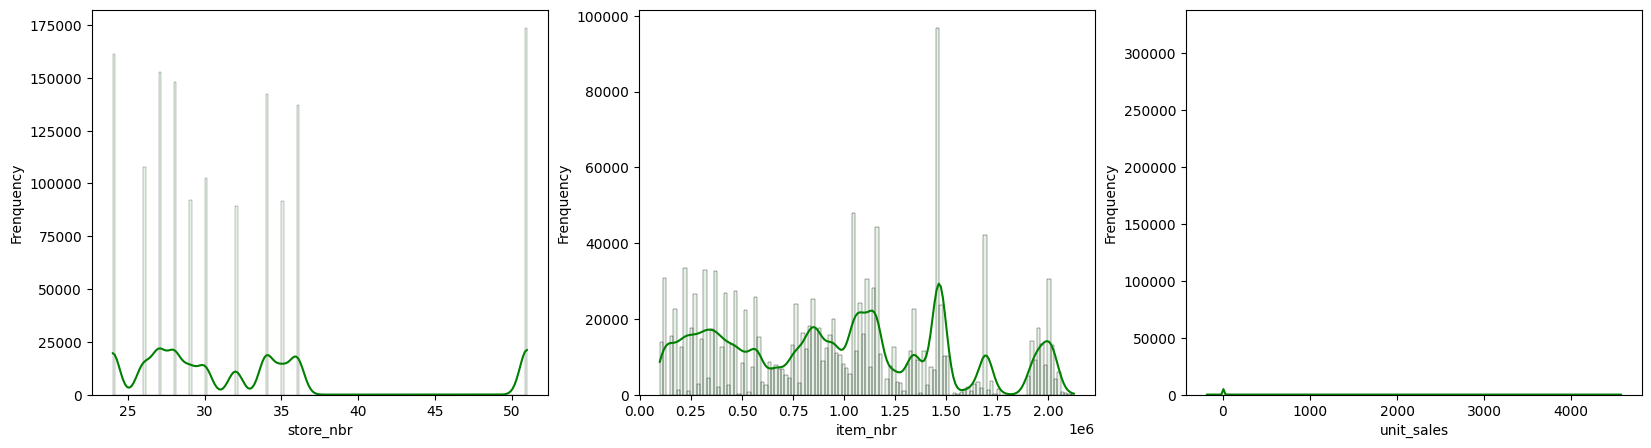

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))       # axes here is a 2D array.
sns.set_style("darkgrid")                             # Setting the background style to "darkgrid".
axes = axes.flatten()                                 # By flattening the axes, we convert it in an 1D array such that it can be iterable.
for i, col in enumerate(num_cols_to_plot):            # enumerate allows us to iterate with i through axes and col through df_num_columns.
  g = sns.histplot(                                   # By assigning the plot to a variable(g) we have more control over it.
                   df_train,                          # Passing the dataset.
                   x = col,                           # Passing the column ww want to plot.
                   kde = True,                        # By setting the Kernel Density Estimate parameter to True, the chart will contain a smoothed curve.
                   ax = axes[i],                      # We're asking python to plot the col in the i-th subplot(axes[i])
                   color = "g",                       # Setting the color to blue.
                   edgecolor= "black",                # Setting the edge color to black.
                   alpha = 0.1                        # Setting the parameter or argument alpha(transparency) = 0.7.
                  )
  g.set(xlabel=col, ylabel="Frenquency")              # Setting the x and y label.
plt.show()                                            # Showing the plot.

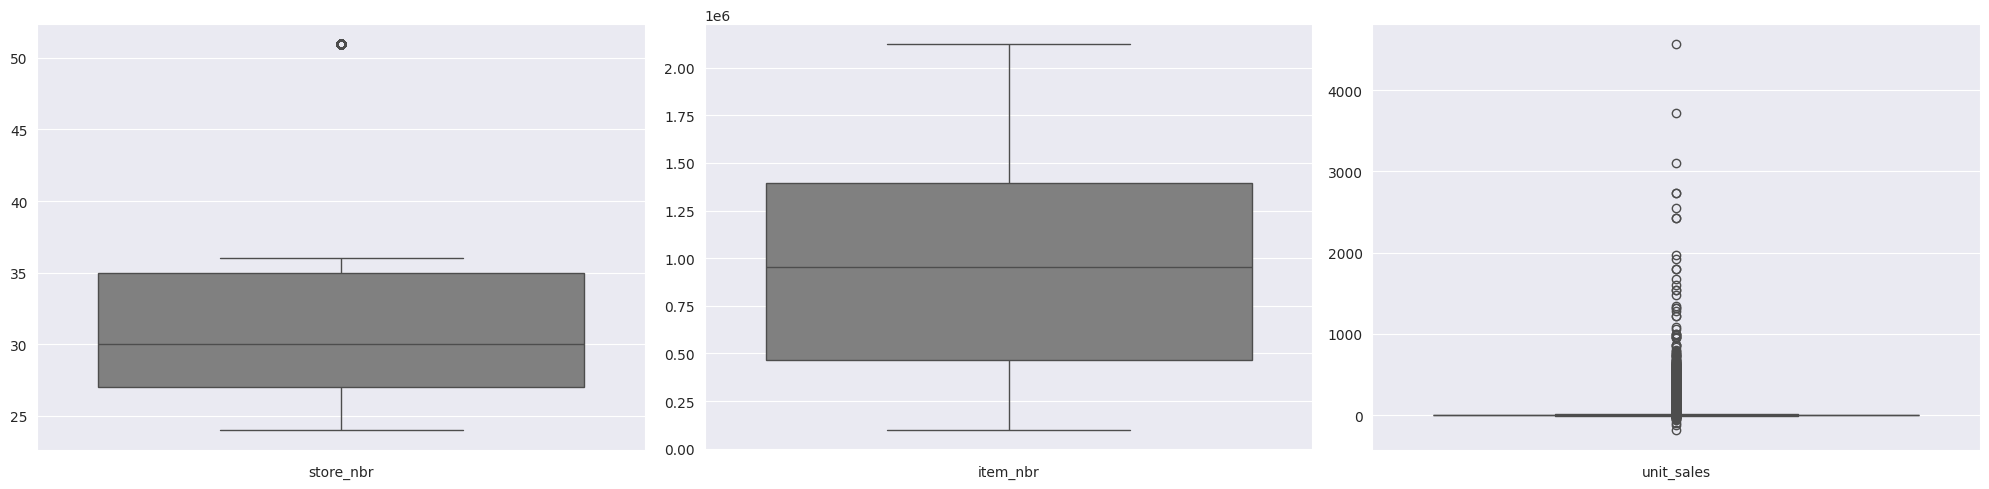

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))       # axes here is a 2D array.
sns.set_style("ticks")                                # Setting the background style to "darkgrid".
axes = axes.flatten()                                 # By flattening the axes, we convert it in an 1D array such that it can be iterable.
for i, col in enumerate(num_cols_to_plot):            # enumerate allows us to iterate with i through axes and col through df_num_columns.
  g = sns.boxplot(                                    # By assigning the plot to a variable(g) we have more control over it.
                   df_train,                          # Passing the dataset.
                   y = col,                           # Passing the column ww want to plot.
                   ax = axes[i],                      # We're asking python to plot the col in the i-th subplot(axes[i])
                   color = "gray",                    # Setting the color to blue.
                  )
  g.set(xlabel=col, ylabel='')                        # Setting the x and y label.
plt.tight_layout()
plt.show()                                            # Showing the plot.

In [ ]:
# Since negative values of unit_sales represent the return of items, we will replace them with 0 (no sales).

df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [ ]:
df_train["unit_sales"].min()

0.0

In [ ]:
df_train["unit_sales"].max()

4573.0

In [ ]:
# Outliers identification.


def store_item_zscore(group):
    """
    group: A subset of the DataFrame corresponding to a single store-item combination.
    """

    # 1. Calculate the average sales for this group
    mean_sales = group['unit_sales'].mean()

    # 2. Calculate how much sales vary within this group
    std_sales = group['unit_sales'].std()

    # 3. Z-score formula:
    #       z = (value - mean) / std
    #    If std = 0 → all values are equal → value - mean = 0 → z = 0.
    #    To avoid the zero division error, we replace std with 1 when it's 0:
    #       - This keeps the math valid (no crash).
    safe_std = std_sales if std_sales != 0 else 1
    group['z_score'] = (group['unit_sales'] - mean_sales) / safe_std

    return group


# Apply the function to each (store_nbr, item_nbr) combination
df_train_grouped = (
    df_train
    .groupby(['store_nbr', 'item_nbr'], group_keys = False)
    .apply(store_item_zscore, include_groups = True)  # Keep grouped columns inside the df
)

# Remove the multi-index created by groupby + apply
df_train_grouped = df_train_grouped.reset_index(drop=True, inplace = False)

# And finally identify the upper outliers: z_score > 3
# If the lower outliers can be mathematically defined(z_score < -3), they are normal values, hense they should be kept.
outliers = df_train_grouped[df_train_grouped['z_score'] > 3]

# Summary
print(f"Number of outliers detected: {len(outliers)}\n\n")
outliers.head()

Number of outliers detected: 22674




/tmp/ipython-input-399309306.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(store_item_zscore, include_groups = True)  # Keep grouped columns inside the df


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
43,11762096,2013-09-28,30,1047674,15.0,False,4.575150
83,37950221,2014-12-22,26,418238,10.0,False,3.160501
184,19699804,2014-03-01,36,564274,24.0,False,3.055647
196,98164216,2016-11-27,27,518094,102.0,True,6.808733
205,117863774,2017-06-04,28,115893,23.0,True,3.974011


In [ ]:
# outliers impact reduction: log function
df_train_grouped['unit_sales_log'] = np.log1p(df_train_grouped['unit_sales']) # log1p = log(1 + x) which avoids issues with 0
# np.expm1(df_train_grouped['unit_sales_log'])   gives back the original values

In [ ]:
df_train_grouped[df_train_grouped['z_score'] < -3]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log
258739,107023852,2017-02-21,51,1473394,0.925,False,-3.039469,0.654926


### **STEP 3: Fill missing DATES with zero sales**:


Since TS models expect a complete calendar, if a day is skipped entirely, the model can’t tell whether the gap means “zero sold” or “no data”.

Filling those gaps with explicit zeros keeps the story straight and prevents hard-to-debug errors later on.

In [ ]:
# Goal: every product in every store has one row per calendar day. If nothing sold, unit_sales should be 0.

In [ ]:
df_train_grouped.shape

(1398849, 8)

In [ ]:
# Make sure the date column is a real datetime
df_train_grouped['date'] = pd.to_datetime(df_train_grouped['date'])

In [ ]:
def fill_calendar(group):

    #
    # group contains all rows for ONE (store_nbr, item_nbr) pair
    #
    g = group.set_index("date").sort_index()   # use date/calendar as the index
    g = g.asfreq("D", fill_value=0)   # creates extra rows for the missing days and fills every numeric col with 0 in those new rows

    # put the identifiers back (asfreq drops them)
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    return g.reset_index()                     # date back to a normal column

df_train_grouped = (
    df_train_grouped
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar, include_groups = True)  # Keep grouped columns inside the df)
)

/tmp/ipython-input-2360995281.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar, include_groups = True)  # Keep grouped columns inside the df)


In [ ]:
df_train_grouped.shape

(24283478, 8)

###  **Step 4: Feature Engineering**


**New feature** ------------------------------- **Why it helps the model**

year   -------------------------------------------- Captures long-term growth or decline, e.g. sales rise every year.

month ---------------------------------------- Picks up holiday seasons (November-December), back-to-school spikes, etc.

day -------------------------------------------- Useful for month-end or mid-month payday surges.

day_of_week ----------------------------- Reveals weekend vs. weekday patterns—Friday grocery rush, Sunday lull.

In [ ]:
# Make sure 'date' is a real datetime


# Split the timestamp into model-friendly parts
df_train_grouped['date'] = pd.to_datetime(df_train_grouped['date'])
df_train_grouped['year'] = df_train_grouped['date'].dt.year
df_train_grouped['month'] = df_train_grouped['date'].dt.month
df_train_grouped['day'] = df_train_grouped['date'].dt.day
df_train_grouped['day_of_week'] = df_train_grouped['date'].dt.dayofweek

# Check the new cols out
df_train_grouped.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week
0,2013-01-17,622071,24,96995,2.0,False,0.0,1.098612,2013,1,17,3
1,2013-01-18,0,24,96995,0.0,0,0.0,0.000000,2013,1,18,4
2,2013-01-19,0,24,96995,0.0,0,0.0,0.000000,2013,1,19,5
3,2013-01-20,0,24,96995,0.0,0,0.0,0.000000,2013,1,20,6
4,2013-01-21,0,24,96995,0.0,0,0.0,0.000000,2013,1,21,0


In [ ]:
# 7-day rolling average of unit_sales, per (item, store)
df_train_grouped = df_train_grouped.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True) # make sure rows are in time order

df_train_grouped["unit_sales_7d_avg"] = (
    df_train_grouped
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]      # isolate one time-series per (item, store), get the units sold
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())       #  mean of last 7 days, i.e. 7-day moving average, aligned back to original df
)
'''
.groupby(["item_nbr", "store_nbr"])["unit_sales"]
What happens: Splits the DataFrame into thousands of mini-series—one per product in one store—and selects the unit_sales column inside each.
Why it matters: We don’t want sales from Store 10 to mix with Store 11, or item A with item B.
.transform(lambda s: s.rolling(window=7).mean())
What happens:
rolling(window=7) builds a 7-row sliding window that includes the current row and the six before it.
mean() averages what’s inside that window.
transform stitches the result back so it aligns row-for-row with the original DataFrame.
Why it matters:
The first six days in each series return NaN (fewer than 7 observations).
After that, every row holds the weekly average leading up to that day —a smoother signal the model can learn from.
'''

df_train_grouped.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-17,622071,24,96995,2.0,False,0.0,1.098612,2013,1,17,3,2.000000
1,2013-01-18,0,24,96995,0.0,0,0.0,0.000000,2013,1,18,4,1.000000
2,2013-01-19,0,24,96995,0.0,0,0.0,0.000000,2013,1,19,5,0.666667
3,2013-01-20,0,24,96995,0.0,0,0.0,0.000000,2013,1,20,6,0.500000
4,2013-01-21,0,24,96995,0.0,0,0.0,0.000000,2013,1,21,0,0.400000


In [ ]:
# Lets see how the new column unit_sales_7d_avg looks like. For that, we'll need to select a store and item.
# Get store and item from the first row
store_id = df_train_grouped.iloc[1000]['store_nbr']
item_id = df_train_grouped.iloc[1000]['item_nbr']

# Filter the DataFrame for this store-item pair
sample = df_train_grouped[(df_train_grouped['store_nbr'] == store_id) & (df_train_grouped['item_nbr'] == item_id)]
sample.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week,unit_sales_7d_avg
775,2013-05-10,5398704,36,96995,4.0,False,3.007162,1.609438,2013,5,10,4,4.000000
776,2013-05-11,0,36,96995,0.0,0,0.000000,0.000000,2013,5,11,5,2.000000
777,2013-05-12,0,36,96995,0.0,0,0.000000,0.000000,2013,5,12,6,1.333333
778,2013-05-13,0,36,96995,0.0,0,0.000000,0.000000,2013,5,13,0,1.000000
779,2013-05-14,0,36,96995,0.0,0,0.000000,0.000000,2013,5,14,1,0.800000


In [ ]:
df_train_grouped.shape

(24283478, 13)

In [ ]:
df_train_grouped.to_csv('guayas_prepared.csv', index = False)

### **Step 5: Time-Series Data Viz**

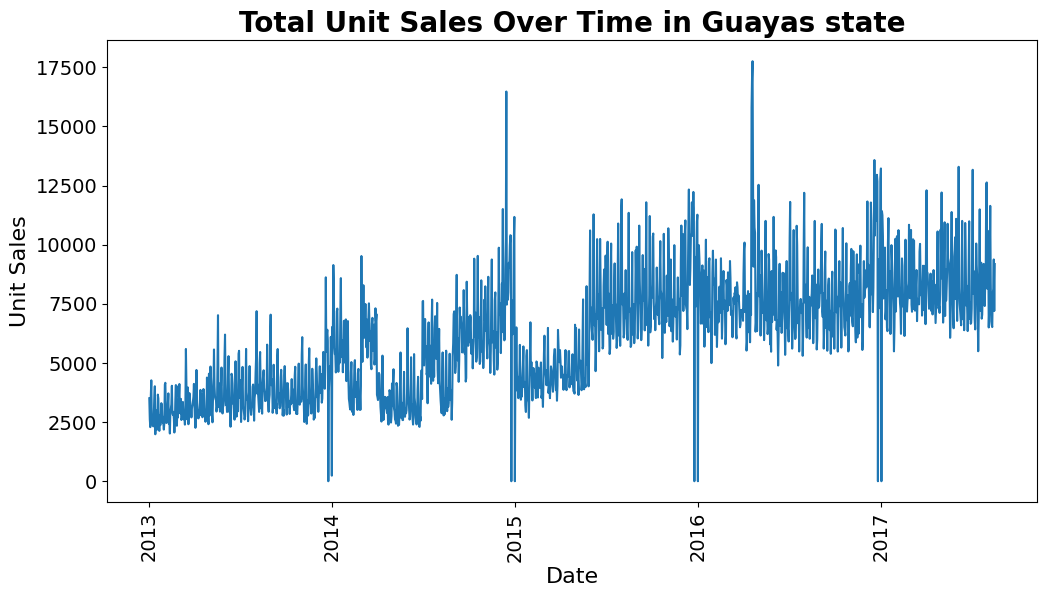

In [ ]:
# 1. Aggregating total sales by date
sales_by_date = df_train_grouped.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.show()

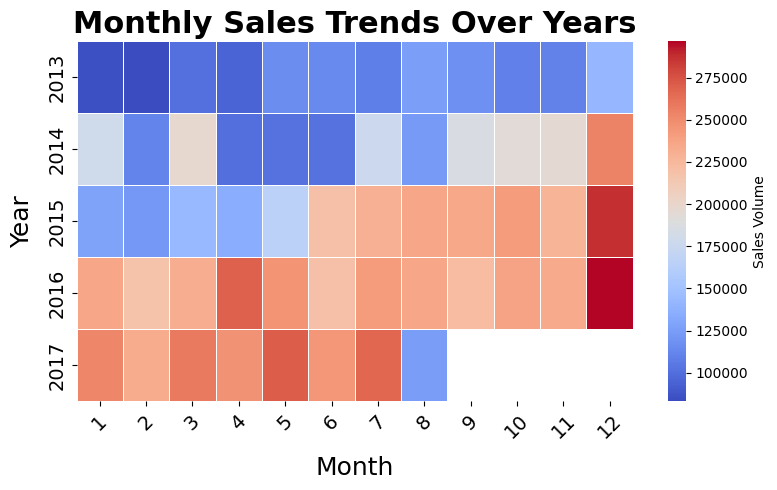

In [ ]:
# 1. Aggregating sales by year and month
    # .unstack(): reshapes the table so that: Each row is a year, Each column is a month (1–12), The values are total sales.
sales_by_month = df_train_grouped.groupby(['year', 'month'])['unit_sales'].sum().unstack()



# 2. Plotting heatmap of sales by year and month

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

In [ ]:
df_train_grouped.shape

In [ ]:
# Path to save the file
from google.colab import drive
import pandas as pd

# Mount Drive
drive.mount('/content/drive')

# Path to load the file
load_path = "/content/drive/MyDrive/tsa_ms_project/df_train_grouped.pkl"

# Load DataFrame
df_train_grouped = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


In [ ]:
df_train_grouped[df_train_grouped['z_score'].isna()]

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week,unit_sales_7d_avg
375163,2016-01-07,66994613,30,115891,1.0,False,NaN,0.693147,2016,1,7,3,1.0
687364,2013-09-11,10988047,27,125430,2.0,False,NaN,1.098612,2013,9,11,2,2.0
1457568,2013-03-08,2698875,35,205557,1.0,False,NaN,0.693147,2013,3,8,4,1.0
2603305,2016-03-06,72563510,32,264753,1.0,False,NaN,0.693147,2016,3,6,6,1.0
2776135,2013-05-30,6278430,34,268623,2.0,False,NaN,1.098612,2013,5,30,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24283459,2017-08-08,124736958,36,2123410,6.0,False,NaN,1.945910,2017,8,8,1,6.0
24283460,2017-08-14,125336138,24,2123727,2.0,False,NaN,1.098612,2017,8,14,0,2.0
24283461,2017-08-12,125179467,51,2123727,1.0,False,NaN,0.693147,2017,8,12,5,1.0
24283462,2017-08-13,125230200,24,2123791,2.0,False,NaN,1.098612,2017,8,13,6,2.0


### **Step 6: Examining the Impact of Holidays**

In [ ]:
# 1. Peek at the holiday file
df_holiday_events.head(2)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [ ]:
# 2. Convert date to a real datetime and check the range
'''
Why?
Pandas understands datetimes; this makes joins, plots and time filtering easy.
'''
# Convert date column to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


In [ ]:
# 3. Join holidays onto our sales table
df_train_holiday = pd.merge(
    df_train_grouped,                     # daily sales
    df_holiday_events[['date', 'type']],  # keep only what we need
    on='date',
    how='left'                    # non-holiday days get NaN in 'type'
)
df_train_holiday.shape

(24750280, 14)

In [ ]:
df_train_holiday.isna().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
z_score,354
unit_sales_log,0
year,0
month,0


In [ ]:
df_train_holiday['type']=df_train_holiday['type'].fillna('Work Day')

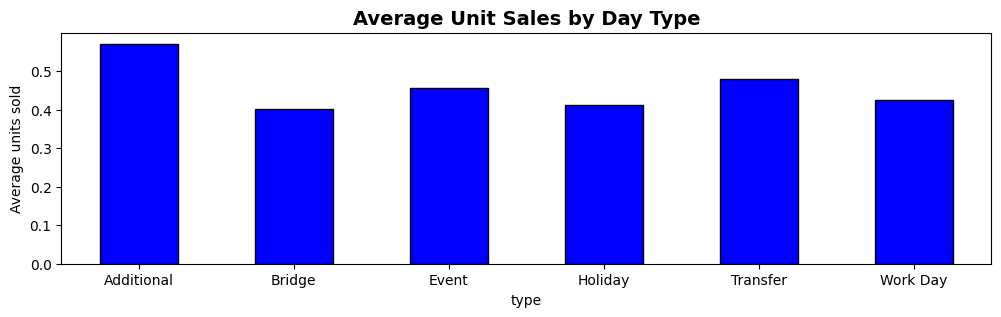

In [ ]:
# On an average day, how many units sell when it’s a Holiday vs. a normal Work Day?
# 4. Compare average sales for each holiday type
# 1–2  average units sold for each day-type
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# 3  bar chart
holiday_sales.plot(kind='bar', figsize=(12,3), color='b', edgecolor='black')
plt.title('Average Unit Sales by Day Type', fontsize=14, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

In [ ]:

# Path to save the file
from google.colab import drive
import pandas as pd
save_path = "/content/drive/MyDrive/tsa_ms_project/df_train_holiday.pkl"

# Save DataFrame
df_train_holiday.to_pickle(save_path)
print(f"Saved to: {save_path}")


'''
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Path to load the file
load_path = "/content/drive/MyDrive/tsa_ms_project/df_train_holiday.pkl"

# Load DataFrame
df_train_holiday = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")
'''

Saved to: /content/drive/MyDrive/tsa_ms_project/df_train_holiday.pkl


'\nfrom google.colab import drive\n\n# Mount Drive\ndrive.mount(\'/content/drive\')\n\n# Path to load the file\nload_path = "/content/drive/MyDrive/tsa_ms_project/df_train_holiday.pkl"\n\n# Load DataFrame\ndf_train_holiday = pd.read_pickle(load_path)\nprint("DataFrame reloaded, ready to go!")\n'

### **Step 7: Analyzing Perishable Items**

In [ ]:
# 1. Let’s take a look at the items dataset, which has the 'perishable' column.

df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [ ]:
# NON OF THE TOP3_FAMILY HAS PERISHABLE ITEMS.
df_items.loc[df_items['perishable'] == 1, 'family'].unique()

array(['BREAD/BAKERY', 'DELI', 'POULTRY', 'EGGS', 'DAIRY', 'MEATS',
       'SEAFOOD', 'PREPARED FOODS', 'PRODUCE'], dtype=object)

In [ ]:
# 2. Add the “perishable” flag to our training table
'''
Why? df_train only knows how many items sold; it doesn’t know which of those items spoil.
Merging in the flag lets us split the sales into two buckets, and see how much sales change when a product is flagged as perishable or non-perishable.
We will also set the proper type (boolean) for the 'perishable' column.
'''

# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train_holiday, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
df_train_items[df_train_items['perishable']==True].head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week,unit_sales_7d_avg,type,family,class,perishable
15729701,2013-03-28,3539621,24,1149069,2.0,False,-0.806352,1.098612,2013,3,28,3,2.000000,Work Day,PRODUCE,2070,True
15729702,2013-03-29,0,24,1149069,0.0,0,0.000000,0.000000,2013,3,29,4,1.000000,Work Day,PRODUCE,2070,True
15729703,2013-03-30,0,24,1149069,0.0,0,0.000000,0.000000,2013,3,30,5,0.666667,Work Day,PRODUCE,2070,True
15729704,2013-03-31,0,24,1149069,0.0,0,0.000000,0.000000,2013,3,31,6,0.500000,Work Day,PRODUCE,2070,True
15729705,2013-04-01,0,24,1149069,0.0,0,0.000000,0.000000,2013,4,1,0,0.400000,Holiday,PRODUCE,2070,True


In [ ]:
# 3. Compare total sales for perishable vs. non-perishable

# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()
perishable_sales

,unit_sales
perishable,
False,8.935371e+06
True,1.670084e+06


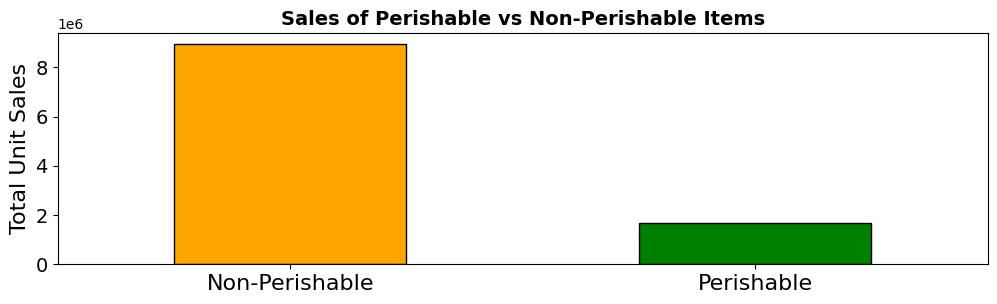

In [ ]:
# 3. Compare total sales for perishable vs. non-perishable

# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,3))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=14, weight = 'bold')
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

In [4]:
# Path to save the file
'''
save_path = "/content/drive/MyDrive/tsa_ms_project/df_train_items.pkl"

# Save DataFrame
df_train_items.to_pickle(save_path)
print(f"Saved to: {save_path}")

'''
# Mount Drive
drive.mount('/content/drive')

# Path to load the file
load_path = "/content/drive/MyDrive/tsa_ms_project/df_train_items.pkl"

# Load DataFrame
df_train_items = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


### **Step 8: Analyzing the Impact of Oil Prices**

In [8]:
# Make sure the date column is a real datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Merging df_train with oil data on date
df_train_oil = pd.merge(df_train_items, df_oil, on='date', how='left')

In [12]:
df_train_oil['dcoilwtico'].describe() # from here we can see that the distribution is skweded, therefore we will impute the missing
                                      # values with the median

,dcoilwtico
count,1.693853e+07
mean,6.172156e+01
std,2.401455e+01
min,2.619000e+01
25%,4.537000e+01
50%,5.030000e+01
75%,9.190000e+01
max,1.106200e+02


In [13]:
df_train_oil['dcoilwtico'] = df_train_oil['dcoilwtico'].fillna(df_train_oil['dcoilwtico'].median())

In [14]:
df_train_oil.isna().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
z_score,354
unit_sales_log,0
year,0
month,0


In [5]:
'''
# Path to save the file
save_path = "/content/drive/MyDrive/tsa_ms_project/df_train_oil.pkl"

# Save DataFrame
df_train_oil.to_pickle(save_path)
print(f"Saved to: {save_path}")

'''


# Path to load the file
load_path = "/content/drive/MyDrive/tsa_ms_project/df_train_oil.pkl"

# Load DataFrame
df_train_oil = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")

DataFrame reloaded, ready to go!


In [6]:
# Filter for a single store
df_store = df_train_oil[df_train_oil['store_nbr'] == 24]

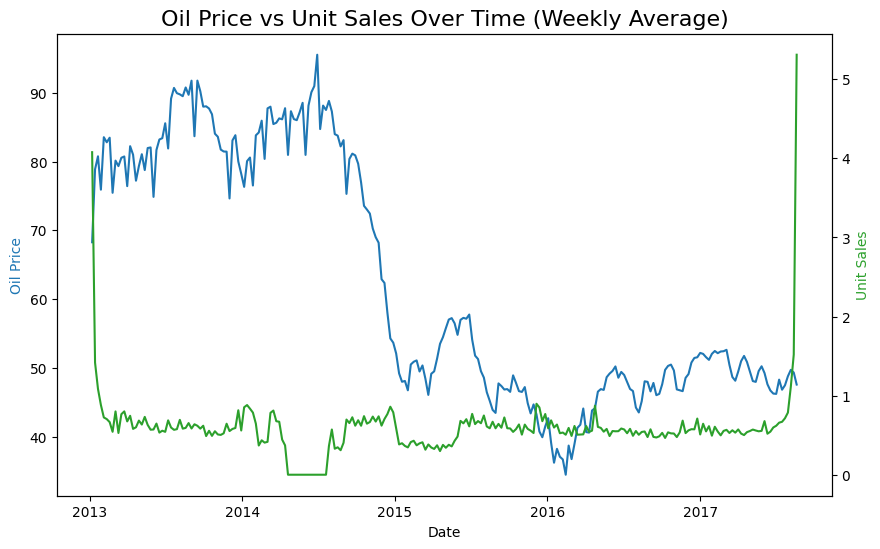

In [7]:
# Set date as index for resampling
df_store = df_store.set_index('date')

# Resample to weekly averages (numeric cols only)
df_resampled = df_store.resample('W').mean(numeric_only = True)

# Reset index so 'date' becomes a column again for plotting
df_resampled = df_resampled.reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price', color='tab:blue')
ax1.plot(df_resampled['date'], df_resampled['dcoilwtico'], color='tab:blue', label='Oil Price')

ax2 = ax1.twinx()
ax2.set_ylabel('Unit Sales', color='tab:green')
ax2.plot(df_resampled['date'], df_resampled['unit_sales'], color='tab:green', label='Unit Sales')

plt.title('Oil Price vs Unit Sales Over Time (Weekly Average)', fontsize=16)
plt.show()
